In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

# Divvy data

## Load and concat the Divvy datasets
Download Divvy 2017 datasets from here: https://www.divvybikes.com/system-data

In [2]:
divvy1 = pd.read_csv('data/Divvy_Trips_2017_Q1Q2/Divvy_Trips_2017_Q1.csv', parse_dates=['start_time', 'end_time'])
divvy2 = pd.read_csv('data/Divvy_Trips_2017_Q1Q2/Divvy_Trips_2017_Q2.csv', parse_dates=['start_time', 'end_time'])
divvy3 = pd.read_csv('data/Divvy_Trips_2017_Q3Q4/Divvy_Trips_2017_Q3.csv', parse_dates=['start_time', 'end_time'])
divvy4 = pd.read_csv('data/Divvy_Trips_2017_Q3Q4/Divvy_Trips_2017_Q4.csv', parse_dates=['start_time', 'end_time'])

divvy = pd.concat([divvy1, divvy2, divvy3, divvy4], ignore_index=True)

divvy.to_csv('data/divvy_2017.csv', index=False)

In [3]:
divvy = pd.read_csv('data/divvy_2017.csv')

In [4]:
station_list = set(list(divvy['from_station_name'].unique()) + list(divvy['to_station_name'].unique()))

In [5]:
len(station_list)

593

In [6]:
divvy.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,13518905,2017-03-31 23:59:07,2017-04-01 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0
1,13518904,2017-03-31 23:56:25,2017-04-01 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0
2,13518903,2017-03-31 23:55:33,2017-04-01 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0
3,13518902,2017-03-31 23:54:46,2017-03-31 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0
4,13518901,2017-03-31 23:53:33,2017-04-01 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0


## Load Divvy station info for GPS coordinates
Download the stations json file from the same location: https://www.divvybikes.com/system-data

In [7]:
with open('data/stations.json') as json_data:
    station_data = json.load(json_data)

In [8]:
station_data['stationBeanList'][:2]

[{'altitude': '',
  'availableBikes': 0,
  'availableDocks': 39,
  'city': 'Chicago',
  'id': 2,
  'is_renting': True,
  'kioskType': 'K3_FULL',
  'landMark': '15541',
  'lastCommunicationTime': '2018-10-09 13:09:02',
  'latitude': 41.87647,
  'location': '',
  'longitude': -87.62034,
  'postalCode': '60605',
  'stAddress1': 'Buckingham Fountain',
  'stAddress2': '',
  'stationName': 'Buckingham Fountain',
  'status': 'IN_SERVICE',
  'statusKey': 1,
  'statusValue': 'In Service',
  'testStation': False,
  'totalDocks': 39},
 {'altitude': '',
  'availableBikes': 28,
  'availableDocks': 26,
  'city': 'Chicago',
  'id': 3,
  'is_renting': True,
  'kioskType': 'K3_FULL',
  'landMark': '15544',
  'lastCommunicationTime': '2018-10-09 13:08:47',
  'latitude': 41.86722595682,
  'location': '',
  'longitude': -87.6153553902,
  'postalCode': '',
  'stAddress1': 'Shedd Aquarium',
  'stAddress2': '',
  'stationName': 'Shedd Aquarium',
  'status': 'IN_SERVICE',
  'statusKey': 1,
  'statusValue': 'I

In [9]:
stations = [station['stationName'] for station in station_data['stationBeanList']]
latitude = [station['latitude'] for station in station_data['stationBeanList']]
longitude = [station['longitude'] for station in station_data['stationBeanList']]

In [10]:
# unknown = []
# for station in station_list:
#     if station not in stations:
#         unknown.append(station)
# unknown

In [11]:
station_gps = pd.DataFrame({'station_name': stations, 'latitude': latitude, 'longitude': longitude})

In [12]:
divvy = divvy.merge(station_gps, how='left', left_on=['from_station_name'], right_on=['station_name'])
divvy = divvy.rename(index=str, columns={"latitude": "from_station_latitude", "longitude": "from_station_longitude"})

divvy = divvy.merge(station_gps, how='left', left_on=['to_station_name'], right_on=['station_name'])
divvy = divvy.rename(index=str, columns={"latitude": "to_station_latitude", "longitude": "to_station_longitude"})

divvy.drop(['station_name_x', 'station_name_y'], axis=1, inplace=True)

In [13]:
divvy.to_csv('data/divvy_2017.csv', index=False)

In [14]:
divvy = pd.read_csv('data/divvy_2017.csv')

### 1) Top 5 stations with the most starts (showing # of starts)

In [15]:
station_starts = divvy.groupby(['from_station_name'])['from_station_name'].count().sort_values(ascending=False)
station_starts.head()

from_station_name
Streeter Dr & Grand Ave         97571
Lake Shore Dr & Monroe St       53400
Canal St & Adams St             50911
Clinton St & Washington Blvd    49832
Theater on the Lake             47908
Name: from_station_name, dtype: int64

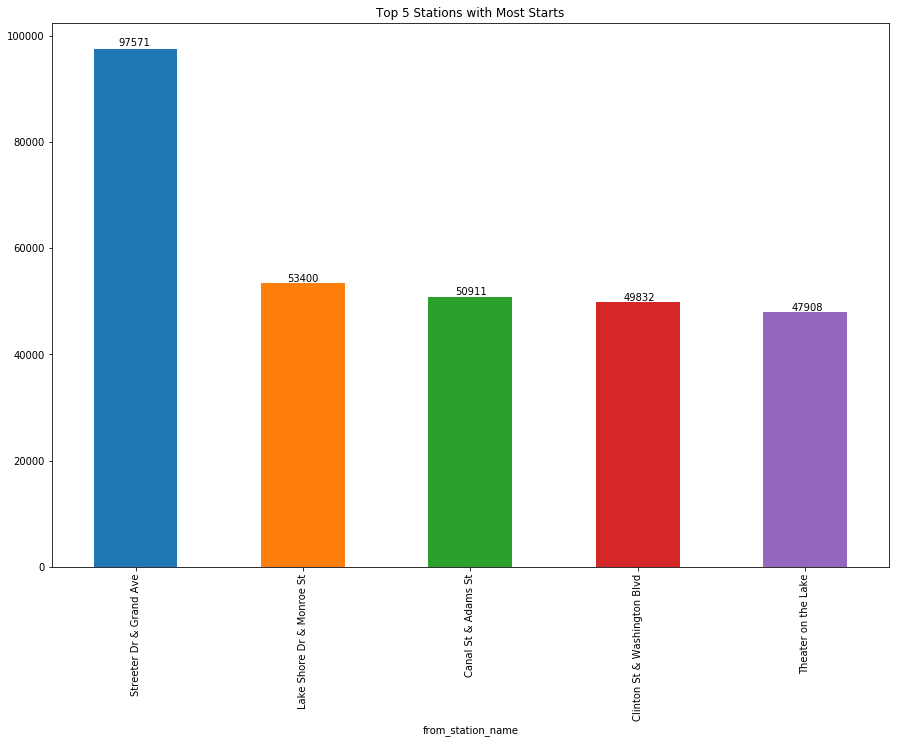

In [16]:
ax = station_starts.head(5).plot(kind='bar', figsize=(15, 10), title='Top 5 Stations with Most Starts')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + .15, p.get_height() * 1.005))

### 2) Trip duration by user type

In [17]:
trip_duration = divvy.groupby(['usertype'])['tripduration'].mean().sort_values(ascending=False)
trip_duration

usertype
Customer      1856.081443
Dependent      751.857143
Subscriber     703.787619
Name: tripduration, dtype: float64

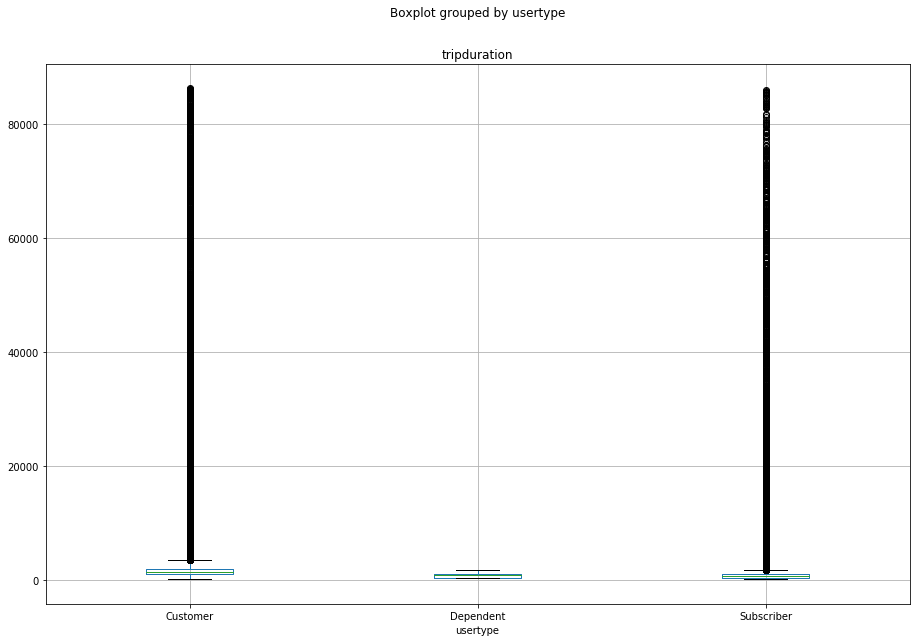

In [18]:
ax = divvy.boxplot(column='tripduration', by='usertype', figsize=(15,10))

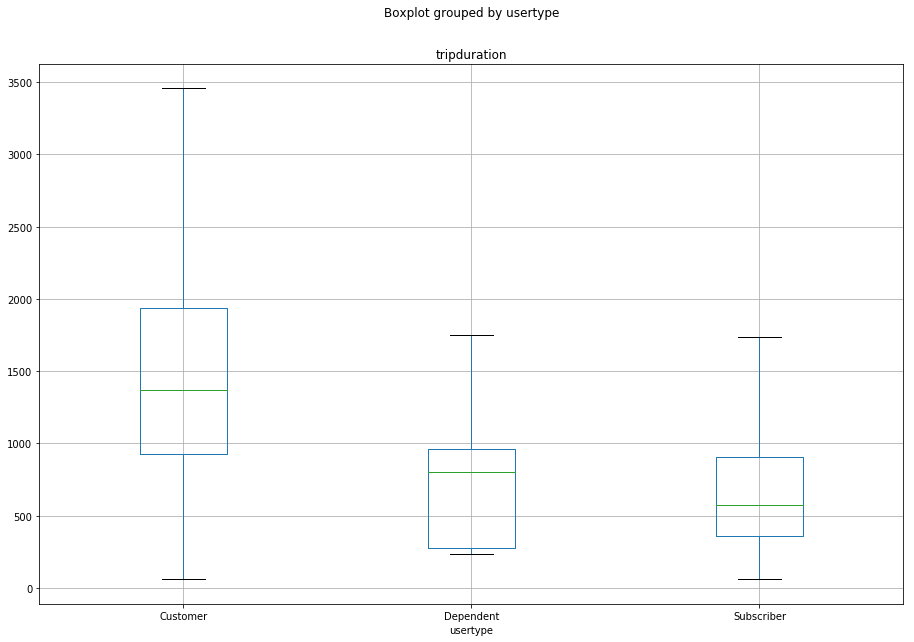

In [19]:
ax = divvy.boxplot(column='tripduration', by='usertype', figsize=(15,10), showfliers=False)

### 3) Most popular trips based on start station and stop station

In [20]:
divvy['trip_stations'] = divvy['from_station_name'] + ' TO ' + divvy['to_station_name']

In [21]:
trip_stations = divvy.groupby(['trip_stations'])['trip_stations'].count().sort_values(ascending=False)
trip_stations.head()

trip_stations
Lake Shore Dr & Monroe St TO Streeter Dr & Grand Ave     12171
Streeter Dr & Grand Ave TO Streeter Dr & Grand Ave       10042
Streeter Dr & Grand Ave TO Theater on the Lake            8180
Streeter Dr & Grand Ave TO Lake Shore Dr & North Blvd     7993
Lake Shore Dr & North Blvd TO Streeter Dr & Grand Ave     7226
Name: trip_stations, dtype: int64

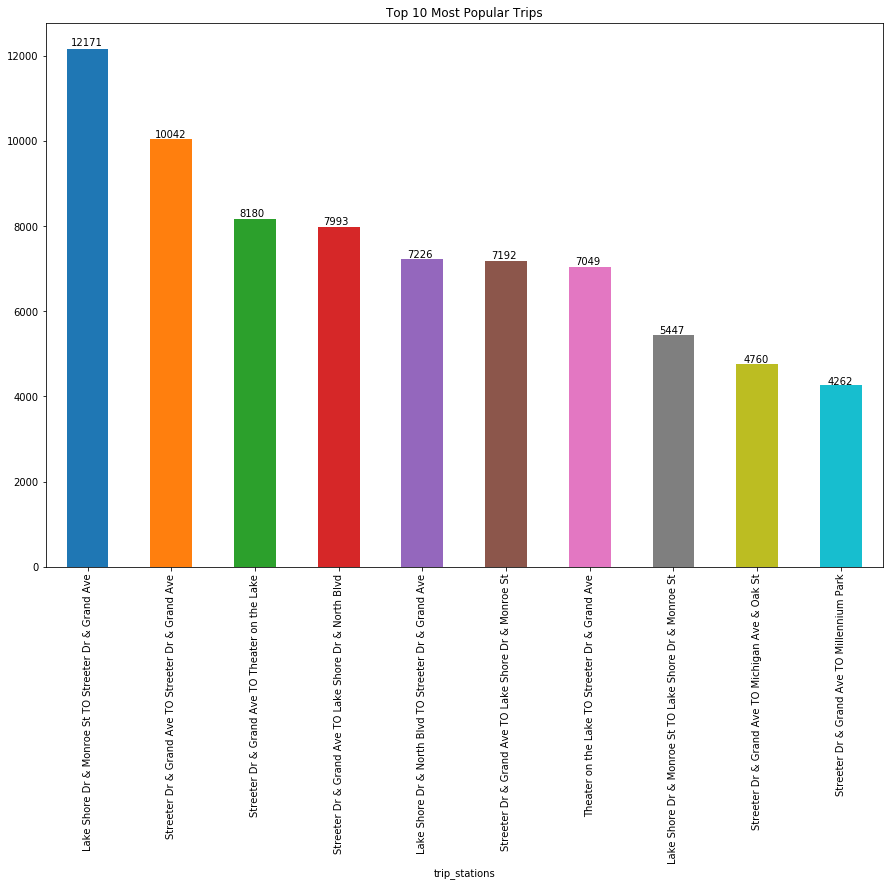

In [22]:
ax = trip_stations.head(10).plot(kind='bar', figsize=(15, 10), title='Top 10 Most Popular Trips')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + .05, p.get_height() * 1.005))

### Create dataframe of paths for Tableau chart

In [23]:
trip_dict = {'path': list(trip_stations.index), 'frequency': list(trip_stations.values)}
trip_dict['origin'] = [x.split(' TO ')[0] for x in trip_dict['path']]
trip_dict['destination'] = [x.split(' TO ')[1] for x in trip_dict['path']]

In [24]:
from collections import defaultdict

trips = defaultdict(list)

for idx in range(len(trip_dict['path'])):
    trips['path'].append(trip_dict['path'][idx])
    trips['frequency'].append(trip_dict['frequency'][idx])
    trips['origin-destination'].append('origin')
    trips['station'].append(trip_dict['origin'][idx])
    
    trips['path'].append(trip_dict['path'][idx])
    trips['frequency'].append(trip_dict['frequency'][idx])
    trips['origin-destination'].append('destination')
    trips['station'].append(trip_dict['destination'][idx])

In [25]:
stations_gps = (divvy[divvy['from_station_name'].duplicated()]
                [['from_station_name', 'from_station_latitude', 'from_station_longitude']].reset_index(drop=True))

In [26]:
trips_df = pd.DataFrame(trips).merge(stations_gps.drop_duplicates(subset=['from_station_name']),
                                     how='left',
                                     left_on='station',
                                     right_on='from_station_name')

In [27]:
trips_df.drop(['from_station_name'], axis=1, inplace=True)

In [28]:
trips_df.to_csv('data/divvy_trips.csv')

### 4) Rider performance by Gender and Age based on avg trip distance (station to station), median speed (distance traveled / trip duration)

Multiply geodesic distance by 1.25. Routes follow roads but the calculated route is direct (geodesic). A route straight down a road would be the same as the direct route; a route diagonal to roads would be multiplied by 1.414 (thanks, Pythagoras!); assuming routes are evenly split between diagonal and direct, with some wiggle room, I'm splitting the difference at 1.25.

I looked at using the Google Maps api to calculate the actual, along-the-road distance, but they've removed the free api key option. I also looked at Bing Maps, but it's rate limited and I have more than 98,000 routes in this dataset (and once I saw how big that number was, I realized that using api calls would take more than a few days!). So I opted for this *x1.25* method which is less accurate but far quicker and cheaper.

In [29]:
from math import isnan
from geopy import distance

def find_distance(row):
    if (not isnan(row['from_station_latitude']) and
        not isnan(row['from_station_longitude']) and
        not isnan(row['to_station_latitude']) and
        not isnan(row['to_station_longitude'])):
        dist = (1.25 * (distance.distance((row['from_station_latitude'], row['from_station_longitude']),
                                          (row['to_station_latitude'], row['to_station_longitude'])).m))
        return dist
    else:
        return np.nan

In [30]:
divvy['trip_distance'] = divvy.apply(find_distance, axis=1)
divvy['speed'] = divvy['trip_distance'] / divvy['tripduration']

In [31]:
divvy.to_csv('data/divvy_2017.csv')

In [32]:
divvy = pd.read_csv('data/divvy_2017.csv')

### 5) What is the busiest bike in Chicago in 2017? How many times was it used? How many minutes was it in use?

In [33]:
divvy.head()

,Unnamed: 0,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,from_station_latitude,from_station_longitude,to_station_latitude,to_station_longitude,trip_stations,trip_distance,speed
0,0,13518905,2017-03-31 23:59:07,2017-04-01 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,Clinton St & Lake St TO May St & Cullerton St,4423.016189,5.161046
1,1,13518904,2017-03-31 23:56:25,2017-04-01 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,41.891466,-87.626761,41.890359,-87.617532,Wabash Ave & Grand Ave TO McClurg Ct & Illinoi...,969.675670,4.108795
2,2,13518903,2017-03-31 23:55:33,2017-04-01 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0,42.015962,-87.668570,42.009074,-87.674190,Greenview Ave & Jarvis Ave TO Clark St & Lunt Ave,1119.470513,3.216869
3,3,13518902,2017-03-31 23:54:46,2017-03-31 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,41.893992,-87.629318,41.894503,-87.617854,Dearborn St & Erie St TO McClurg Ct & Erie St,1191.329565,4.136561
4,4,13518901,2017-03-31 23:53:33,2017-04-01 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0,41.921540,-87.653818,NaN,NaN,Sheffield Ave & Webster Ave TO Halsted St & Bl...,NaN,NaN


In [34]:
bikes = divvy.groupby(['bikeid']).count()['trip_id'].sort_values(ascending=False)

In [35]:
bike_number = bikes.index[0]

In [36]:
rides = bikes.iloc[0]

In [37]:
minutes_used = (divvy.groupby(['bikeid']).sum()['tripduration'] / 60).loc[bike_number]

In [38]:
print('Bike number {} was ridden {} times in 2017 for a total of {} minutes'
      .format(bike_number, rides, int(minutes_used)))

Bike number 2565 was ridden 1489 times in 2017 for a total of 22526 minutes


# Yelp data
Download Yelp datasets from here: https://www.yelp.com/dataset/

In [39]:
business = pd.read_json('data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)

checkin = pd.read_json('data/yelp_dataset/yelp_academic_dataset_checkin.json', lines=True)

max_records = 1e5
df = pd.read_json('data/yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=max_records)
review = pd.DataFrame() # Initialize the dataframe
try:
    for df_chunk in df:
        review = pd.concat([review, df_chunk])
except ValueError:
    print ('\nSome messages in the file cannot be parsed')

In [40]:
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB


In [41]:
checkin.head()

,business_id,time
0,7KPBkxAOEtb3QeIL9PEErg,"{'Fri-0': 2, 'Sat-0': 1, 'Sun-0': 1, 'Wed-0': ..."
1,kREVIrSBbtqBhIYkTccQUg,"{'Mon-13': 1, 'Thu-13': 1, 'Sat-16': 1, 'Wed-1..."
2,tJRDll5yqpZwehenzE2cSg,"{'Thu-0': 1, 'Mon-1': 1, 'Mon-12': 1, 'Sat-16'..."
3,tZccfdl6JNw-j5BKnCTIQQ,"{'Sun-14': 1, 'Fri-18': 1, 'Mon-20': 1}"
4,r1p7RAMzCV_6NPF0dNoR3g,"{'Sat-3': 1, 'Sun-18': 1, 'Sat-21': 1, 'Sat-23..."


In [42]:
review.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,iCQpiavjjPzJ5_3gPD5Ebg,0,2011-02-25,0,x7mDIiDB3jEiPGPHOmDzyw,2,The pizza was okay. Not the best I've had. I p...,0,msQe1u7Z_XuqjGoqhB0J5g
1,pomGBqfbxcqPv14c3XH-ZQ,0,2012-11-13,0,dDl8zu1vWPdKGihJrwQbpw,5,I love this place! My fiance And I go here atl...,0,msQe1u7Z_XuqjGoqhB0J5g
2,jtQARsP6P-LbkyjbO1qNGg,1,2014-10-23,1,LZp4UX5zK3e-c5ZGSeo3kA,1,Terrible. Dry corn bread. Rib tips were all fa...,3,msQe1u7Z_XuqjGoqhB0J5g
3,elqbBhBfElMNSrjFqW3now,0,2011-02-25,0,Er4NBWCmCD4nM8_p1GRdow,2,Back in 2005-2007 this place was my FAVORITE t...,2,msQe1u7Z_XuqjGoqhB0J5g
4,Ums3gaP2qM3W1XcA5r6SsQ,0,2014-09-05,0,jsDu6QEJHbwP2Blom1PLCA,5,Delicious healthy food. The steak is amazing. ...,0,msQe1u7Z_XuqjGoqhB0J5g


In [43]:
checkin['checkins'] = checkin['time'].apply(lambda x : sum(x.values()))
yelp = business.merge(checkin, on='business_id', how='outer')

In [44]:
review['date'] = pd.to_datetime(review['date'])
review = review[review['date'].dt.year == 2017]

In [45]:
business.to_csv('data/yelp_business.csv', index=False)
checkin.to_csv('data/yelp_checkin.csv', index=False)
review.to_csv('data/yelp_review.csv', index=False)
yelp.to_csv('data/yelp.csv', index=False)

In [46]:
business = pd.read_csv('data/yelp_business.csv')
checkin = pd.read_csv('data/yelp_checkin.csv')
review = pd.read_csv('data/yelp_review.csv')
yelp = pd.read_csv('data/yelp.csv')

### Find the top 10 and bottom 10 restaurants in Illinois having most and least checkins respectively.

In [47]:
yelp.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,time,checkins
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,NaN,T2E 6L6,24,4.0,AB,"{'Fri-0': 1, 'Sun-0': 3, 'Thu-0': 1, 'Fri-1': ...",29.0
1,NaN,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,NaN,89002,3,4.5,NV,{'Sun-1': 1},1.0
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC,"{'Mon-0': 1, 'Sun-0': 1, 'Fri-1': 1, 'Sun-1': ...",7.0
3,211 W Monroe St,NaN,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,NaN,1,33.449999,-112.076979,Geico Insurance,NaN,85003,8,1.5,AZ,{'Wed-18': 1},1.0
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,NaN,T2H 0N5,4,2.0,AB,"{'Thu-14': 1, 'Thu-20': 1}",2.0


In [48]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'].isnull()) &
         (yelp['is_open'] == 1)])

11

In [49]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'] == 1) &
         (yelp['is_open'] == 1)])

15

In [50]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'] == 2) &
         (yelp['is_open'] == 1)])

12

In [51]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'] == 3) &
         (yelp['is_open'] == 1)])

10

In [52]:
top10 = yelp[(yelp['state'] == 'IL') &
             (yelp['categories'].str.contains('Restaurants') &
              (yelp['is_open'] == 1))
            ].sort_values('checkins', ascending=False).head(10)

bottom10 = yelp[(yelp['state'] == 'IL') &
                (yelp['categories'].str.contains('Restaurants') &
                (yelp['is_open'] == 1))
               ].sort_values('checkins', ascending=False).tail(30)

In [53]:
top10.to_csv('data/yelp_top10_checkins.csv', index=False)
bottom10.to_csv('data/yelp_bottom10_checkins.csv', index=False)

In [54]:
top10_names = top10['name'].tolist()
top10_names

['Sakanaya',
 'Black Dog Smoke & Ale House',
 'DESTIHL Restaurant & Brew Works',
 'Seven Saints',
 'Golden Harbor Authentic Chinese Cuisine',
 'Maize Mexican Grill',
 'Meijer',
 'Cafe Kopi',
 'Courier Cafe',
 'Big Grove Tavern']

In [55]:
bottom10_names = bottom10['name'].tolist()
bottom10_names

['Monicals Pizza',
 'Subway',
 "McDonald's",
 'The Spice Box',
 'Subway',
 'Taco Bell',
 'Subway',
 'Asian Noodle and Sushi',
 'Red Cape Hot Pot',
 "McDonald's",
 'Main Street Belly Deli',
 'Subway',
 'Little Caesars Pizza',
 'Casa Real',
 'Tasty Fish Chicken & Grill',
 "J & J's Burgers & Beer",
 'Casa Del Mar',
 'Dairy Queen',
 'Nanjing Bistro',
 "Bergie's - The Occasional Place",
 'Sushi San',
 "Papa John's Pizza",
 "Domino's Pizza",
 'Golden Kitchen',
 'The Wild Hare',
 'Stango Cuisine',
 "Tortica's Grill",
 'Manzellas Italian Restaurant',
 "Jimmy John's",
 "Domino's Pizza"]

### For the top 10 and bottom 10 restaurants calculated in step 6, calculate the average star rating and average sentiment score of the reviews

In [56]:
top_bottom = top10['business_id'].tolist() + bottom10['business_id'].tolist()

In [57]:
sentiment = review[review['business_id'].isin(top_bottom)]

In [58]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_vader_scores(text):
    '''
    Takes a string of text and outputs four values for Vader's negative,
    neutral, positive, and compound (normalized) sentiment scores
    INPUT: a string
    OUTPUT: a dictionary of four sentiment scores
    '''

    analyser = SentimentIntensityAnalyzer()
    return analyser.polarity_scores(text)


def apply_vader(df, column):
    '''
    Takes a DataFrame with a specified column of text and adds four new columns
    to the DataFrame, corresponding to the Vader sentiment scores
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with four additional columns
    '''

    sentiment = pd.DataFrame(df[column].apply(get_vader_scores))
    unpacked = pd.DataFrame([d for idx, d in sentiment[column].iteritems()],
                            index=sentiment.index)
    unpacked['compound'] += 1
    columns = {'neu': 'neutral', 'pos': 'positive', 'neg': 'negative'}
    unpacked.rename(columns=columns, inplace=True)
    return pd.concat([df, unpacked], axis=1)

In [59]:
sentiment = apply_vader(sentiment, 'text')

In [60]:
top10_sentiment = {}
for biz_id in top10['business_id'].tolist():
    top10_sentiment[yelp.loc[yelp['business_id'] == biz_id, 'name'].iloc[0]] = sentiment[sentiment['business_id'] == biz_id].groupby(['business_id']).mean()

In [61]:
top10_scores = pd.DataFrame()
for restaurant in top10_sentiment:
    top10_scores = top10_scores.append(pd.DataFrame(top10_sentiment[restaurant]))
top10_scores.reset_index(level=0, inplace=True)

In [62]:
top10_scores['name'] = top10_scores['business_id'].apply(lambda business_id: yelp['name']
                                                         [(yelp['business_id'] == business_id)].values[0])

In [63]:
top10_scores

,business_id,cool,funny,stars,useful,compound,negative,neutral,positive,name
0,-zEpEmDfFQL-ph0N3BDlXA,0.160920,0.011494,4.413793,0.275862,1.860336,0.019851,0.699230,0.280862,Sakanaya
1,9MnbQg7kfb_WgxoV0hXKSQ,0.136364,0.022727,4.409091,0.272727,1.872034,0.027705,0.721068,0.251227,Black Dog Smoke & Ale House
2,-fiUXzkxRfbHY9TKWwuptw,0.160377,0.037736,4.018868,0.273585,1.796705,0.034849,0.712745,0.252406,DESTIHL Restaurant & Brew Works
3,L2c-qKZWumCmOCR-dqBLrg,0.333333,0.145833,4.416667,0.458333,1.773444,0.030250,0.720354,0.249458,Seven Saints
4,t_yiQnxUDdPPCN2z4QyezA,0.342105,0.118421,4.302632,0.828947,1.620366,0.055934,0.748132,0.195816,Golden Harbor Authentic Chinese Cuisine
5,VIJ2KiDKhUVhhpNylEIfog,0.160000,0.040000,4.160000,0.220000,1.729708,0.033660,0.751300,0.215040,Maize Mexican Grill
6,XbHxWOciYlBhJOjKRQbo9g,0.333333,0.000000,3.166667,0.666667,1.453317,0.049667,0.777167,0.173000,Meijer
7,e0prCZXtHGQIKeQ_wTW3uw,0.052632,0.105263,3.842105,0.368421,1.799100,0.036842,0.696263,0.266947,Cafe Kopi
8,o13eH93qmWVNFZogkjhd9w,0.157895,0.000000,4.368421,0.368421,1.878182,0.024026,0.707500,0.268474,Courier Cafe
9,dn9lwYUxmhs_mLKPu7L25Q,0.106383,0.212766,2.936170,0.787234,1.552809,0.058340,0.759660,0.181979,Big Grove Tavern


In [64]:
bottom10_sentiment = {}
for biz_id in bottom10['business_id'].tolist():
    bottom10_sentiment[yelp.loc[yelp['business_id'] == biz_id, 'name'].iloc[0]] = sentiment[sentiment['business_id'] == biz_id].groupby(['business_id']).mean()

In [65]:
bottom10_scores = pd.DataFrame()
for restaurant in bottom10_sentiment:
    bottom10_scores = bottom10_scores.append(pd.DataFrame(bottom10_sentiment[restaurant]))
bottom10_scores.reset_index(level=0, inplace=True)

In [66]:
bottom10_scores['name'] = bottom10_scores['business_id'].apply(lambda business_id: yelp['name']
                                                               [(yelp['business_id'] == business_id)].values[0])

In [67]:
bottom10_scores

,business_id,cool,funny,stars,useful,compound,negative,neutral,positive,name
0,DLhAuWok29OU8VR-DBxP7A,1.000000,0.0,5.000000,0.000000,1.921700,0.000000,0.694000,0.306000,Monicals Pizza
1,N9osJe0lQOdnd3xLUkJVMw,0.500000,0.0,5.000000,0.000000,1.948100,0.000000,0.699000,0.301000,Subway
2,fsBAaw7xwHWB78HRSWwQEQ,0.000000,0.0,5.000000,0.000000,1.970700,0.000000,0.660000,0.340000,The Spice Box
3,hH7qhup_bGKr9r27RpHJPw,0.000000,0.0,1.000000,0.666667,0.798367,0.069000,0.906000,0.024667,Taco Bell
4,ZvSy8yaly9Aeh64Qm4Dsfw,1.100000,0.9,3.400000,2.300000,1.382270,0.080200,0.751200,0.168700,Red Cape Hot Pot
5,IFlSq9YWXHZyLnuh0EffKQ,0.666667,0.0,4.666667,0.666667,1.940767,0.023000,0.721000,0.256333,Main Street Belly Deli
6,ks6JgGsz7phkGEVh9hoHkg,0.000000,0.0,2.333333,0.000000,0.827967,0.093000,0.840000,0.067000,Little Caesars Pizza
7,AW_d5hMf7sI6yHrz4Ujv8w,1.000000,0.5,3.500000,1.500000,1.901750,0.035000,0.809000,0.156500,Casa Real
8,62Ibju8UmUZtPIBLDS_nUw,0.000000,0.0,1.750000,0.250000,0.990875,0.116750,0.776750,0.106500,Tasty Fish Chicken & Grill
9,sDfN5qJlmvrwTfwEPBsxSg,0.000000,0.0,1.000000,0.000000,0.300300,0.293000,0.707000,0.000000,Dairy Queen


In [68]:
top10_scores.to_csv('data/yelp_top_scores.csv', index=False)
bottom10_scores.to_csv('data/yelp_bottom_scores.csv', index=False)

### What are the top 10 Cuisine types (Mexican, American, Thai, etc) based on the number of restaurants and number of check ins

In [69]:
restaurants = yelp[yelp['categories'].str.contains('Restaurants', na=False)]

In [70]:
pd.options.mode.chained_assignment = None  # default='warn'
restaurants['categories'] = restaurants['categories'].apply(lambda x: x.split(', '))

In [71]:
restaurants = restaurants.join(pd.get_dummies(pd.DataFrame(restaurants['categories'].tolist()).stack()).astype(int).sum(level=0))

In [72]:
columns = [item for item in restaurants.columns.tolist() if item not in yelp.columns.tolist()]
columns.remove('Restaurants')

In [73]:
num_restaurants = restaurants[columns].sum(numeric_only=True).sort_values(ascending=False)
num_restaurants.head(50)

Food                         3607.0
Nightlife                    2399.0
Bars                         2313.0
Sandwiches                   2166.0
Pizza                        2139.0
Fast Food                    2089.0
American (Traditional)       2083.0
Breakfast & Brunch           1566.0
Burgers                      1558.0
Italian                      1384.0
Mexican                      1335.0
American (New)               1308.0
Chinese                      1265.0
Coffee & Tea                  992.0
Cafes                         955.0
Chicken Wings                 809.0
Japanese                      794.0
Salad                         736.0
Seafood                       714.0
Event Planning & Services     655.0
Sushi Bars                    641.0
Canadian (New)                614.0
Delis                         591.0
Mediterranean                 530.0
Barbeque                      526.0
Asian Fusion                  519.0
Steakhouses                   517.0
Specialty Food              

In [74]:
checkin_dict ={}
for item in columns:
    cnt = restaurants[restaurants[item] == 1].groupby([item])['checkins'].sum()
    if cnt.empty:
        checkin_dict[item] = 0
    else:
        checkin_dict[item] = restaurants[restaurants[item] == 1].groupby([item])['checkins'].sum().values[0]

In [75]:
checkin_dict = pd.Series(checkin_dict).sort_values(ascending=False)

In [76]:
checkin_dict.head(20)

Food                         586066.0
Nightlife                    425034.0
Bars                         412979.0
Sandwiches                   340887.0
Pizza                        324931.0
Fast Food                    323460.0
American (Traditional)       301669.0
Breakfast & Brunch           240952.0
Mexican                      234984.0
Burgers                      232747.0
Chinese                      199874.0
Italian                      194569.0
American (New)               192660.0
Coffee & Tea                 155729.0
Chicken Wings                139867.0
Japanese                     130470.0
Cafes                        129573.0
Event Planning & Services    120586.0
Salad                        115175.0
Thai                         115110.0
dtype: float64

In [77]:
for item in checkin_dict.keys()[:50]:
    print(item)

Food
Nightlife
Bars
Sandwiches
Pizza
Fast Food
American (Traditional)
Breakfast & Brunch
Mexican
Burgers
Chinese
Italian
American (New)
Coffee & Tea
Chicken Wings
Japanese
Cafes
Event Planning & Services
Salad
Thai
Seafood
Specialty Food
Canadian (New)
Sports Bars
Sushi Bars
Caterers
Steakhouses
Pubs
Barbeque
Delis
Desserts
Mediterranean
Asian Fusion
Bakeries
Indian
Beer
Wine & Spirits
Diners
Buffets
Korean
Lounges
Greek
Wine Bars
Cocktail Bars
Vegetarian
Middle Eastern
Gluten-Free
Vietnamese
Soup
French


In [78]:
pd.DataFrame(checkin_dict).to_csv('data/yelp_cuisine_checkin.csv')
pd.DataFrame(num_restaurants).to_csv('data/yelp_cuisine_restaurants.csv')

### What are the most popular keywords or adjectives that reviewers use for the above list of cuisines (calculated in step 8)

In [79]:
cuisine_list = ['American (Traditional)', 'Mexican', 'Chinese', 'Italian', 'American (New)',
               'Japanese', 'Thai', 'Mediterranean', 'Asian Fusion', 'Indian', 'Korean',
                'Greek', 'Middle Eastern', 'Vietnamese', 'French', 'Tex-Mex', 'Caribbean']
cuisines = pd.DataFrame()
for cuisine in cuisine_list:
    businesses = yelp[yelp['categories'].str.contains(cuisine, na=False)]['business_id'].tolist()
    temp = review[review['business_id'].isin(businesses)]
    temp['cuisine'] = cuisine
    cuisines = pd.concat([cuisines, temp], ignore_index=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [80]:
cuisines.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,cuisine
0,gZGsReG0VeX4uKViHTB9EQ,0,2017-08-16,0.0,51RHs_V_fjuistnuKxNpEg,5.0,Finally! After trying many Mexican restaurants...,0.0,5ngpW5tf3ep680eG1HxHzA,Mexican
1,yz66FIUPDKGhILDWzRLeKg,0,2017-11-18,0.0,85DRIjwPJOTb4q0qOlBstw,1.0,I wish i could tell you all about the food but...,1.0,Fc_nb6N6Sdurqb-rwsY1Bw,Mexican
2,vvHr2uKKIhfxVk-fYDmX9Q,0,2017-04-01,0.0,_5rlmreTSW0FVHvdJluRyg,1.0,This Del Taco is just sad. We have been here t...,1.0,GrgjO23ba8soKwyW6BECuw,Mexican
3,VH2BjFjc9usDquDgoHhptA,0,2017-12-05,0.0,TSqSiHfqtBigBa6ia59K7w,5.0,Amazing tacos! A must try if you're in the are...,0.0,SZHWhyG7WxJZdGp6fBVlRg,Mexican
4,YBb-sAYuFv86MGfwQP5Ojg,0,2017-03-19,0.0,qv65IQbhyJT9MeJHTv6hNQ,4.0,Best margaritas around! The food is all a la c...,0.0,1ryvfb9F6hYoCZZZaqeCOA,Mexican


In [81]:
import spacy
from collections import Counter

nlp = spacy.load('en')

nlp.max_length = 1500000

In [82]:
cuisine_docs = {}

for cuisine in cuisine_list:
    print()
    print(cuisine)
    text = cuisines[cuisines['cuisine'] == cuisine]['text'].str.cat(sep=' ')
    chunk_size = 1000000
    num_chunks = len(text) // chunk_size + 1
    
    words = []
    adj = []
    
    for chunk in range(num_chunks):
        print('  chunk', chunk + 1, 'of', num_chunks)
        chunk_start = chunk_size * (chunk - 1)
        chunk_end = chunk_size * chunk
        chunk_text = text[chunk_start: chunk_end]
    
        doc = nlp(chunk_text)
        # all tokens that arent stop words or punctuations
        words.extend([token.text for token in doc if
                      token.is_stop !=True and token.is_punct != True])

        # adjective tokens that arent stop words or punctuations
        adj.extend([token.text for token in doc if
                    token.is_stop != True and
                    token.is_punct != True and token.pos_ == "ADJ"])

    # 200 most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common(200)

    # five most common adjective tokens
    adj_freq = Counter(adj)
    common_adj = adj_freq.most_common(200)
    
    cuisine_docs[cuisine] = {'words': words,
                               'adj': adj,
                               'common_words': common_words,
                               'common_adj': common_adj}


American (Traditional)
  chunk 1 of 1

Mexican
  chunk 1 of 34
  chunk 2 of 34
  chunk 3 of 34
  chunk 4 of 34
  chunk 5 of 34
  chunk 6 of 34
  chunk 7 of 34
  chunk 8 of 34
  chunk 9 of 34
  chunk 10 of 34
  chunk 11 of 34
  chunk 12 of 34
  chunk 13 of 34
  chunk 14 of 34
  chunk 15 of 34
  chunk 16 of 34
  chunk 17 of 34
  chunk 18 of 34
  chunk 19 of 34
  chunk 20 of 34
  chunk 21 of 34
  chunk 22 of 34
  chunk 23 of 34
  chunk 24 of 34
  chunk 25 of 34
  chunk 26 of 34
  chunk 27 of 34
  chunk 28 of 34
  chunk 29 of 34
  chunk 30 of 34
  chunk 31 of 34
  chunk 32 of 34
  chunk 33 of 34
  chunk 34 of 34

Chinese
  chunk 1 of 24
  chunk 2 of 24
  chunk 3 of 24
  chunk 4 of 24
  chunk 5 of 24
  chunk 6 of 24
  chunk 7 of 24
  chunk 8 of 24
  chunk 9 of 24
  chunk 10 of 24
  chunk 11 of 24
  chunk 12 of 24
  chunk 13 of 24
  chunk 14 of 24
  chunk 15 of 24
  chunk 16 of 24
  chunk 17 of 24
  chunk 18 of 24
  chunk 19 of 24
  chunk 20 of 24
  chunk 21 of 24
  chunk 22 of 24
  chunk 2

In [83]:
for cuisine in cuisine_docs.keys():
    with open('data/yelp_cuisine_' + cuisine + '.json', 'w') as fp:
        json.dump(cuisine_docs[cuisine], fp)

In [84]:
cuisine_adj = pd.DataFrame()

for cuisine in cuisine_docs.keys():
    if len(cuisine_docs[cuisine]['adj']) > 0:
        temp = pd.DataFrame({'adj': cuisine_docs[cuisine]['adj'], 'cuisine': cuisine})
        cuisine_adj = pd.concat([cuisine_adj, temp], ignore_index=True)

In [85]:
adjectives = cuisine_adj['adj'].unique().tolist()

In [86]:
'''
from collections import Counter
c = Counter(cuisine_adj['adj'])
adjectives = list(Counter({k: c for k, c in c.items() if c >= 20}))
'''

"\nfrom collections import Counter\nc = Counter(cuisine_adj['adj'])\nadjectives = list(Counter({k: c for k, c in c.items() if c >= 20}))\n"

In [87]:
cuisine_adj['compound'] = np.nan
cuisine_adj['negative'] = np.nan
cuisine_adj['neutral'] = np.nan
cuisine_adj['positive'] = np.nan

In [88]:
'''
from threading import Thread
from time import sleep
from queue import Queue

def get_one_result(text, Queue):
    sentiment = get_vader_scores(text)
    queue.put(sentiment)
    
threads = []
queue = Queue()
total = len(adjectives)
threshold = int(total / 100)
cnt = 0

for adjective in adjectives:
    t = Thread(target=get_one_result, args=(adjective, queue))
    threads.append(t)
    t.start()
    t.join()
    sentiment = queue.get()
    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'compound'] = sentiment['compound']
    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'negative'] = sentiment['neg']
    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'neutral'] = sentiment['neu']
    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'positive'] = sentiment['pos']
           
    cnt += 1    
    print(cnt)
    if cnt % 500 == 0:
        print('{:.2f}% complete'.format(100* cnt / total))
'''

"\nfrom threading import Thread\nfrom time import sleep\nfrom queue import Queue\n\ndef get_one_result(text, Queue):\n    sentiment = get_vader_scores(text)\n    queue.put(sentiment)\n    \nthreads = []\nqueue = Queue()\ntotal = len(adjectives)\nthreshold = int(total / 100)\ncnt = 0\n\nfor adjective in adjectives:\n    t = Thread(target=get_one_result, args=(adjective, queue))\n    threads.append(t)\n    t.start()\n    t.join()\n    sentiment = queue.get()\n    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'compound'] = sentiment['compound']\n    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'negative'] = sentiment['neg']\n    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'neutral'] = sentiment['neu']\n    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'positive'] = sentiment['pos']\n           \n    cnt += 1    \n    print(cnt)\n    if cnt % 500 == 0:\n        print('{:.2f}% complete'.format(100* cnt / total))\n"

In [89]:
total = len(adjectives)
threshold = int(total / 100)
cnt = 0

for adjective in adjectives:
    sentiment = get_vader_scores(adjective)
    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'compound'] = sentiment['compound']
    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'negative'] = sentiment['neg']
    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'neutral'] = sentiment['neu']
    cuisine_adj.loc[cuisine_adj['adj'] == adjective, 'positive'] = sentiment['pos']
    
    cnt += 1
    if cnt % threshold == 0:
        print('{:.2f}% complete'.format(100 * cnt / total))

1.00% complete
1.99% complete
2.99% complete
3.99% complete
4.98% complete
5.98% complete
6.98% complete
7.98% complete
8.97% complete
9.97% complete
10.97% complete
11.96% complete
12.96% complete
13.96% complete
14.95% complete
15.95% complete
16.95% complete
17.94% complete
18.94% complete
19.94% complete
20.94% complete
21.93% complete
22.93% complete
23.93% complete
24.92% complete
25.92% complete
26.92% complete
27.91% complete
28.91% complete
29.91% complete
30.90% complete
31.90% complete
32.90% complete
33.90% complete
34.89% complete
35.89% complete
36.89% complete
37.88% complete
38.88% complete
39.88% complete
40.87% complete
41.87% complete
42.87% complete
43.86% complete
44.86% complete
45.86% complete
46.85% complete
47.85% complete
48.85% complete
49.85% complete
50.84% complete
51.84% complete
52.84% complete
53.83% complete
54.83% complete
55.83% complete
56.82% complete
57.82% complete
58.82% complete
59.81% complete
60.81% complete
61.81% complete
62.81% complete
63

In [90]:
cuisine_adj.to_csv('data/yelp_cuisine_adj_sentiment.csv', index=False)

In [91]:
cuisine_df = pd.DataFrame()

for cuisine in cuisine_docs.keys():
    temp = pd.DataFrame({'words': ' '.join(cuisine_docs[cuisine]['words']).replace('\n', ' ').replace('\r', ''),
                         'adj': ' '.join(cuisine_docs[cuisine]['adj']).replace('\n', ' ').replace('\r', ''),
                         'common_words': [cuisine_docs[cuisine]['common_words']],
                         'common_adj': [cuisine_docs[cuisine]['common_adj']]})
    temp['cuisine'] = cuisine
    cuisine_df = pd.concat([cuisine_df, temp], ignore_index=True)

In [92]:
cuisine_df.head(20)

,words,adj,common_words,common_adj,cuisine
0,,,[],[],American (Traditional)
1,Finally After trying Mexican restaurants Phoen...,Mexican authentic Mexican AMAZING Fresh ready ...,"[(I, 170290), ( , 66807), (The, 64525), (food,...","[(good, 35021), (great, 23566), (Mexican, 1490...",Mexican
2,The spicy wonton favorite We ordered round pot...,spicy favorite good better salty okay Great ye...,"[(I, 111244), (The, 45001), ( , 42063), (food,...","[(good, 24698), (great, 11356), (Chinese, 1116...",Chinese
3,Had ruby salad carpaccio salmon ravioli litera...,amazing amazing bad quick cold hot ok busy bes...,"[(I, 147247), ( , 71353), (The, 62021), (food,...","[(good, 30445), (great, 23426), (My, 12007), (...",Italian
4,,,[],[],American (New)
5,Sansotei serves notch ramen They reservations ...,half normal favorite Our spicy exceptional rig...,"[(I, 142615), (The, 58878), ( , 45463), (\n\n,...","[(good, 30031), (great, 18401), (fresh, 9945),...",Japanese
6,I REALLY wanted like place A lot friends menti...,amazing nice great busy amazing yellow generou...,"[(I, 52779), (The, 20374), (food, 18759), ( , ...","[(good, 11000), (great, 6321), (delicious, 393...",Thai
7,This far favorite Mediterranean restaurant Alw...,favorite fresh delightful amazing large primar...,"[(I, 56064), (The, 23747), ( , 21145), (food, ...","[(good, 10908), (great, 7978), (delicious, 523...",Mediterranean
8,The spicy wonton favorite We ordered round pot...,spicy favorite good better salty okay good fri...,"[(I, 109313), (The, 44566), ( , 38044), (\n\n,...","[(good, 23127), (great, 13914), (delicious, 72...",Asian Fusion
9,Non existened service The waiter great liste...,male different Its dreadful worse fast YOUR Ex...,"[(I, 28206), (food, 13771), (The, 12647), ( , ...","[(good, 6598), (Indian, 6398), (great, 3456), ...",Indian


In [93]:
cuisine_df.to_csv('data/yelp_cuisine_words.csv', index=False)

## The Mayor would like Divvy Bike to add a new feature to their kiosks: “Enter a destination and we’ll tell you how long the trip will take”. We need you to build a model that can predict how long a trip will take given a starting point and destination. You will need to get creative about the factors that will predict travel time. For example, weather and traffic patterns may have an impact on Divvy Bike travel time. There is certainly dataout there –you just should find it.

### Download weather data from Weather Underground
Unfortunately, Weather Underground has started charging for their API: https://www.wunderground.com/weather/api

In [94]:
# # Query data in different years
# # You can get keys from https://www.wunderground.com/
# keys = ['***************', '***************', '***************', 
#         '***************', '***************']
# years = [2017]

# for key, year in zip(keys, years):
#     path = './data/weather_' + str(year) + '.csv'
#     if os.path.isfile(path):
#         continue
#     df, _ = query_weather(key=key, year=year, state='IL', area='Chicago')
#     df.to_csv(path, index=False)
#     print('File saved:\t', path)

### so, just join with the Kaggle dataset instead
download the dataset here: https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data

We'll be only extracting the weather information from this dataset

In [95]:
divvy_kaggle = pd.read_csv('data/chicago-divvy-bicycle-sharing-data/data_raw.csv', parse_dates=['starttime', 'stoptime'])

In [96]:
divvy_kaggle = divvy_kaggle[divvy_kaggle['starttime'].dt.year == 2017].reset_index(drop=True)

In [97]:
divvy_kaggle.to_csv('data/divvy_2017_kaggle.csv', index=False)

In [98]:
divvy_kaggle = pd.read_csv('data/divvy_2017_kaggle.csv')

In [99]:
divvy_kaggle.columns

Index(['trip_id', 'usertype', 'gender', 'starttime', 'stoptime',
       'tripduration', 'from_station_id', 'from_station_name',
       'latitude_start', 'longitude_start', 'dpcapacity_start',
       'to_station_id', 'to_station_name', 'latitude_end', 'longitude_end',
       'dpcapacity_end', 'temperature', 'windchill', 'dewpoint', 'humidity',
       'pressure', 'visibility', 'wind_speed', 'precipitation', 'events',
       'rain', 'conditions'],
      dtype='object')

In [100]:
divvy.columns

Index(['Unnamed: 0', 'trip_id', 'start_time', 'end_time', 'bikeid',
       'tripduration', 'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear',
       'from_station_latitude', 'from_station_longitude',
       'to_station_latitude', 'to_station_longitude', 'trip_stations',
       'trip_distance', 'speed'],
      dtype='object')

In [101]:
len(divvy_kaggle)

3826746

In [102]:
len(divvy)

3829014

In [103]:
df = divvy.merge(divvy_kaggle[['trip_id', 'temperature', 'windchill',
                               'dewpoint', 'humidity', 'pressure',
                               'visibility', 'wind_speed',
                               'precipitation', 'events',
                               'rain', 'conditions']], on='trip_id', how='inner')

In [104]:
df.dropna(inplace=True)
df = df[(df['tripduration'] <= 3600) & (df['trip_distance'] >= 200)]

In [105]:
df.to_csv('data/divvy_weather.csv', index=False)

In [106]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'start_time', 'end_time', 'bikeid',
       'tripduration', 'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear',
       'from_station_latitude', 'from_station_longitude',
       'to_station_latitude', 'to_station_longitude', 'trip_stations',
       'trip_distance', 'speed', 'temperature', 'windchill', 'dewpoint',
       'humidity', 'pressure', 'visibility', 'wind_speed', 'precipitation',
       'events', 'rain', 'conditions'],
      dtype='object')

In [107]:
df.head()

,Unnamed: 0,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,...,windchill,dewpoint,humidity,pressure,visibility,wind_speed,precipitation,events,rain,conditions
0,0,13518905,2017-03-31 23:59:07,2017-04-01 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
1,1,13518904,2017-03-31 23:56:25,2017-04-01 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
2,2,13518903,2017-03-31 23:55:33,2017-04-01 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
3,3,13518902,2017-03-31 23:54:46,2017-03-31 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
5,5,13518900,2017-03-31 23:51:17,2017-03-31 23:55:19,3536,242,143,Sedgwick St & Webster Ave,289,Wells St & Concord Ln,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy


In [108]:
df['start_time'] = pd.to_datetime(df['start_time'])

In [109]:
df['day'] = df['start_time'].dt.dayofweek
df['month'] = df['start_time'].dt.month

In [110]:
df = pd.get_dummies(df, columns=['day'], drop_first=True)
df = pd.get_dummies(df, columns=['month'], drop_first=True)
df = pd.get_dummies(df, columns=['usertype'], drop_first=True)
df = pd.get_dummies(df, columns=['events'], drop_first=True)
df = pd.get_dummies(df, columns=['conditions'], drop_first=True)

### Get traffic data for Chicago rush hours: https://www.illinoisvehicle.com/about-us/blog/traffic-patterns-chicago/

In [111]:
df['morning_rush_hour'] = np.where(((df['start_time'].dt.hour > 6) &
                                    (df['start_time'].dt.hour < 10)),
                                    1, 0)

df['evening_rush_hour'] = np.where(((df['start_time'].dt.hour > 15) &
                                    (df['start_time'].dt.hour < 19)),
                                    1, 0)

df['night'] = np.where(((df['start_time'].dt.hour <= 19) &
                        (df['start_time'].dt.hour <= 6)),
                         1, 0)

df['midday'] = np.where(((df['start_time'].dt.hour >= 10) &
                         (df['start_time'].dt.hour <= 15)),
                         1, 0)

In [112]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'start_time', 'end_time', 'bikeid',
       'tripduration', 'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'gender', 'birthyear', 'from_station_latitude',
       'from_station_longitude', 'to_station_latitude', 'to_station_longitude',
       'trip_stations', 'trip_distance', 'speed', 'temperature', 'windchill',
       'dewpoint', 'humidity', 'pressure', 'visibility', 'wind_speed',
       'precipitation', 'rain', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'usertype_Dependent', 'usertype_Subscriber', 'events_cloudy',
       'events_fog', 'events_hazy', 'events_mostlycloudy',
       'events_partlycloudy', 'events_rain', 'events_sleet', 'events_snow',
       'events_tstorms', 'conditions_Drizzle', 'conditions_Fog',
       'conditions_Freezing Rain', 'conditions_Haze', 'c

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [114]:
columns = ['trip_distance', 'temperature', 'windchill', 'dewpoint',
           'humidity', 'pressure', 'visibility', 'wind_speed', 'precipitation',
           'rain', 'morning_rush_hour',
           'evening_rush_hour', 'night', 'midday', 'day_1', 'day_2',
           'day_3', 'day_4', 'day_5', 'day_6', 'month_2', 'month_3',
           'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
           'month_10', 'month_11', 'month_12',
           'usertype_Dependent', 'usertype_Subscriber',
           'events_cloudy', 'events_fog', 'events_hazy',
           'events_mostlycloudy', 'events_partlycloudy', 'events_rain',
           'events_sleet', 'events_snow', 'events_tstorms',
           'conditions_Drizzle', 'conditions_Fog', 'conditions_Freezing Rain',
           'conditions_Haze', 'conditions_Heavy Rain',
           'conditions_Heavy Thunderstorms and Rain', 'conditions_Light Drizzle',
           'conditions_Light Freezing Drizzle', 'conditions_Light Freezing Rain',
           'conditions_Light Hail', 'conditions_Light Rain',
           'conditions_Light Snow', 'conditions_Light Thunderstorms and Rain',
           'conditions_Mist', 'conditions_Mostly Cloudy', 'conditions_Overcast',
           'conditions_Partly Cloudy', 'conditions_Rain',
           'conditions_Scattered Clouds', 'conditions_Smoke', 'conditions_Snow',
           'conditions_Thunderstorm', 'conditions_Thunderstorms and Rain']

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[columns],
                                                    df['tripduration'],
                                                    test_size=0.2, random_state=0)

In [116]:
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6953289274367874

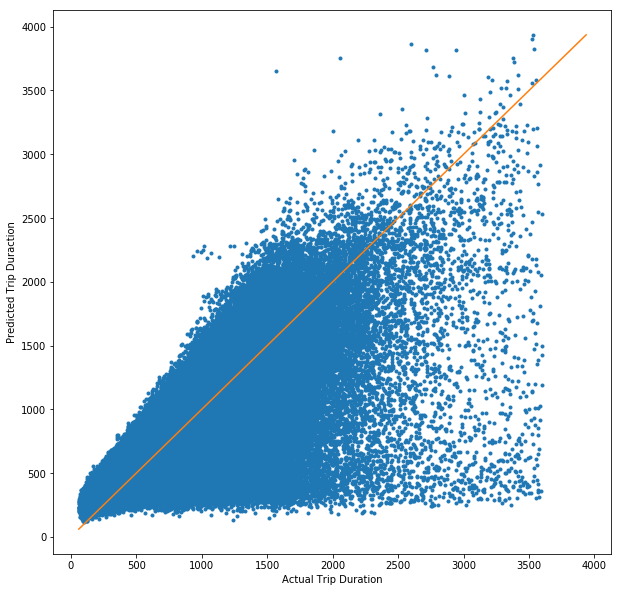

In [118]:
# plot prediction and actual data
y_pred = model.predict(X_test) 
plt.figure(figsize=(10, 10))
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duraction')
plt.plot(y_test, y_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()))
y = x
plt.plot(x, y)
plt.show()

In [119]:
mean_squared_error(y_test, y_pred)

56705.93879952913

In [120]:
model.coef_

array([ 2.01559079e-01,  1.81681156e+00,  1.99016701e-03, -7.95532292e-01,
        6.99892933e-02,  2.00843496e-04,  3.13369952e-03,  2.89675474e-03,
       -2.81145622e-04,  7.51807530e+13, -2.62756523e+01, -2.03026259e+00,
       -6.94605740e+01,  5.00564849e+00, -6.02356835e-01, -2.21197673e+00,
        2.14702399e-01,  7.48525459e+00,  4.99757521e+01,  4.25308631e+01,
       -8.59655627e+00, -1.22898853e+01, -1.90616161e+00,  2.51891509e+00,
        4.81857739e+00,  1.07751601e+01,  1.83172037e+00, -9.35490942e+00,
       -1.10669043e+01, -2.22497333e+00, -1.48064853e+00, -8.15566423e+01,
       -1.39693198e+02,  2.83822409e+14, -2.91699765e+15, -2.43906620e+15,
        9.92973640e+13,  1.04375251e+14,  2.07447956e+14,  2.07447956e+14,
        2.07447956e+14, -5.77469821e+14, -2.07447956e+14,  2.91699765e+15,
       -2.07447956e+14,  2.43906620e+15, -2.82628709e+14,  5.02289068e+14,
       -2.07447956e+14, -2.07447956e+14, -2.82628709e+14, -2.82628709e+14,
       -2.82628709e+14, -

In [121]:
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]).fit(X_train, y_train)
clf.score(X_test, y_test) 

0.6953278183116401

In [122]:
clf.coef_

array([ 2.01579309e-01,  1.83379375e+00,  2.05218927e-03, -8.12559587e-01,
        8.47809783e-02,  6.30086642e-04,  3.07354819e-03,  2.62551335e-03,
       -2.69058743e-04, -2.04949599e+01, -2.63704885e+01, -2.02227581e+00,
       -6.97222106e+01,  5.03017946e+00, -6.21516818e-01, -2.34490139e+00,
        2.29355074e-01,  7.63515442e+00,  4.98576038e+01,  4.24974548e+01,
       -8.65960267e+00, -1.23401242e+01, -1.73734061e+00,  2.58235731e+00,
        4.70202321e+00,  1.06354479e+01,  1.68463725e+00, -9.63829656e+00,
       -1.11646581e+01, -2.18337334e+00, -1.54034748e+00, -1.08561522e+01,
       -1.35108781e+02, -4.42402291e+00, -1.65726059e+00,  1.22564717e-01,
       -1.43572160e+00, -9.72305701e-01,  2.29159435e+01,  3.51120620e+01,
       -1.61664230e+01,  2.49359969e+00,  8.97309615e-01, -1.65726059e+00,
       -2.22802923e+01, -6.30130514e+00, -8.01344971e+00,  3.69860594e+00,
       -2.50028739e+01,  4.16641901e+01,  9.33531149e+00,  3.31239448e+00,
       -1.44241079e+01,  

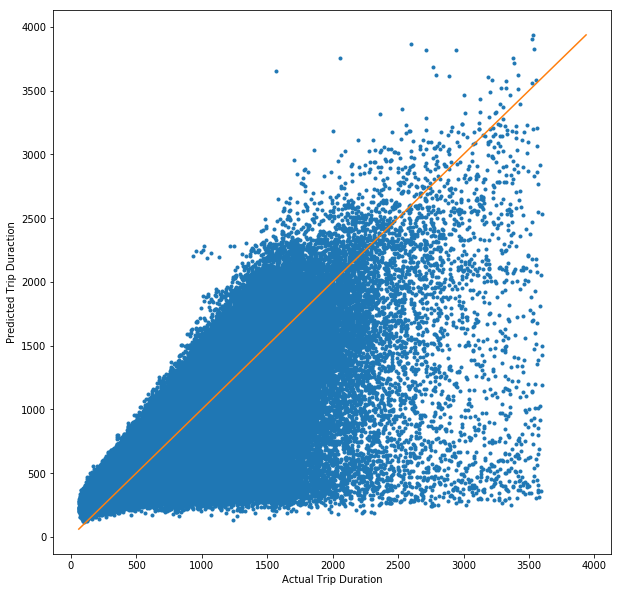

In [123]:
# plot prediction and actual data
y_pred = clf.predict(X_test) 
plt.figure(figsize=(10, 10))
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duraction')
plt.plot(y_test, y_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()))
y = x
plt.plot(x, y)
plt.show()

In [124]:
mean_squared_error(y_test, y_pred)

56706.14523193574

## Improvements:
Use the Google Maps API (https://developers.google.com/maps/documentation/distance-matrix/intro) to extract routes from the origin and destination, improving upon the straight-line distance. But hey, while we're at it, the API also outputs estimated trip duration which is exactly what we're looking for! Unfortuately, Google recently cut off free access to the API. It now costs $0.005 per query.

## The Mayor has a couple of hypothesis which he needs you to verify with the given data. “Do you find a correlation between the star rating and length of reviews?”

In [125]:
review.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,f5O7v_X_jCg2itqacRfxhg,0,2017-10-12,0.0,kS4hrhEScwB9V5JATYjvVQ,5.0,Sansotei serves some top notch ramen. They tak...,0.0,hxqo4NyJFfeOmuoVi--s1A
1,0bjFYstj8USMzEV4ZQldjA,0,2017-01-19,0.0,VKGvSe0SmYcFc5PqjbxLDQ,5.0,"Cool little place, nice atmosphere and staff. ...",0.0,eG6HneK9zLcuZpVuKcsCGQ
2,gZGsReG0VeX4uKViHTB9EQ,0,2017-08-16,0.0,51RHs_V_fjuistnuKxNpEg,5.0,Finally! After trying many Mexican restaurants...,0.0,5ngpW5tf3ep680eG1HxHzA
3,-bd4BQcl1ekgo7avaFngIw,0,2017-06-28,0.0,P7kiSTiwzqm0_LbA71EOPg,5.0,One of the best breakfast places I've been to!...,0.0,5ngpW5tf3ep680eG1HxHzA
4,u73j2VQ3TGWdMO-AG7MABw,0,2017-07-06,0.0,7EgEjUpcb8q-B5dPCMvkaQ,2.0,"Food was alright, the service was HORRIBLE! Bo...",1.0,5ngpW5tf3ep680eG1HxHzA


In [126]:
corr_df = pd.DataFrame()

In [127]:
corr_df['stars'] = review['stars']

In [128]:
corr_df['review_length'] = review['text'].str.len()

In [129]:
corr_df = corr_df.dropna()

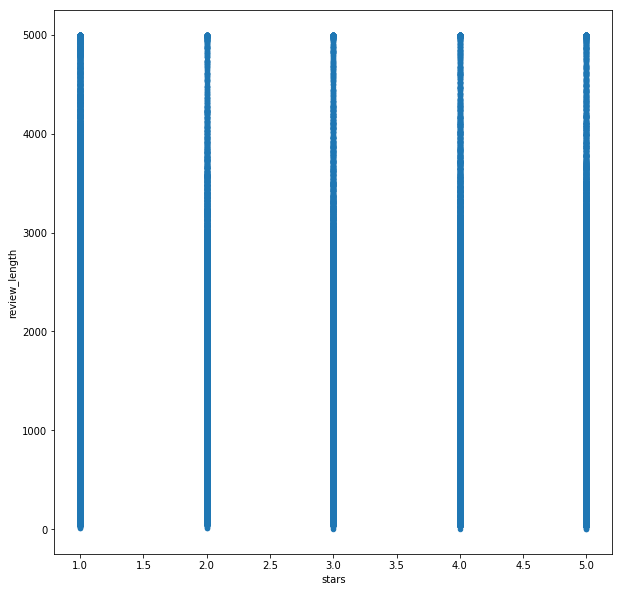

In [130]:
corr_df.plot(x='stars', y='review_length', kind='scatter', style='o', figsize=(10, 10))
plt.show()

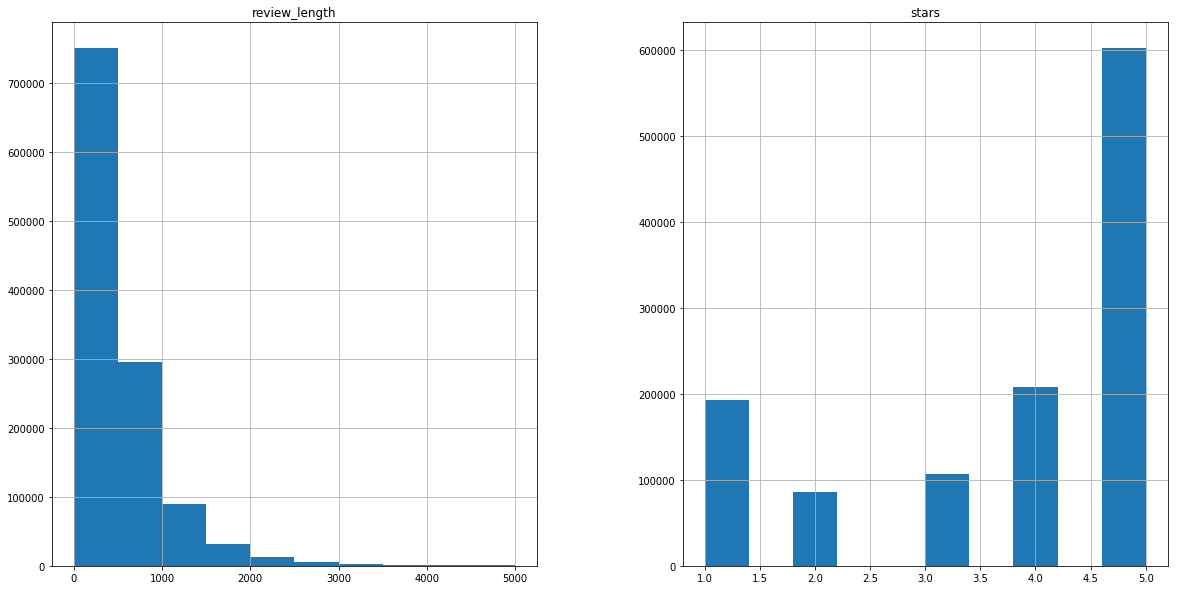

In [131]:
corr_df.hist(figsize=(20, 10))
plt.show()

In [132]:
from scipy.stats import linregress
linregress(corr_df['stars'], corr_df['review_length'])

LinregressResult(slope=-74.60250345114228, intercept=819.8866119452658, rvalue=-0.22207838254262444, pvalue=0.0, stderr=0.2997187072487137)

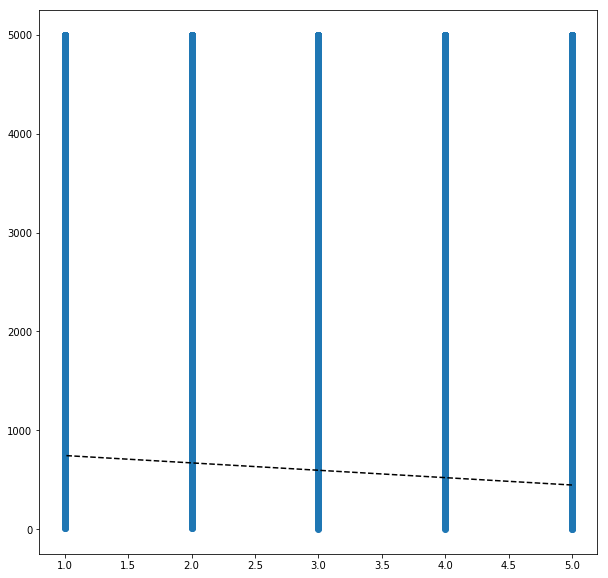

In [133]:
fit = np.polyfit(corr_df['stars'], corr_df['review_length'],1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(corr_df['stars'], corr_df['review_length'], 'o', corr_df['stars'], fit_fn(corr_df['stars']), '--k')
plt.show()

## The Mayor also wants us to identify the topics from the reviews of restaurants and explore if these topics are insightful and whether they can be used as inputs to some other classification or predictive work in the future. To do this learn a set of topics by applying topic modeling algorithms such as LDA on textual reviews. Choose the number of topics in a data-driven fashion such as by using a figure that plots perplexity versus number of topics. 

In [134]:
restaurant_ids = yelp[(yelp['categories'].str.contains('Restaurants') &
                      (yelp['is_open'] == 1))
                     ]['business_id'].tolist()

In [135]:
restaurant_reviews = review[review['business_id'].isin(restaurant_ids)]['text']

In [136]:
doc_complete = restaurant_reviews.tolist()

In [137]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]

In [138]:
len(doc_clean)

670315

In [139]:
doc_clean_sample = doc_clean

# Take a sample of 1000 reviews in order to speed up processing time
# comment out the below line to run LDA on the entire dataset
doc_clean_sample = np.random.choice(doc_clean, 5000, replace=False).tolist()

In [140]:
from sklearn.model_selection import train_test_split

In [141]:
train, test = train_test_split(doc_clean_sample, test_size=0.2, random_state=42)

In [142]:
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(train)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in train]

In [143]:
# num_topics = [5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 400, 500, 600]
num_topics = range(5, 95, 5)

In [144]:
perplexity = []
models = {}

for num in num_topics:
    print(num)
    Lda = gensim.models.ldamodel.LdaModel
    lda_model = Lda(doc_term_matrix,
                    id2word = dictionary,
                    num_topics=num,
                    passes=10,
                    chunksize=50,
                    update_every=1)
    models[str(num)] = lda_model
    perplexity.append(lda_model.log_perplexity([dictionary.doc2bow(doc) for doc in test]))

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90


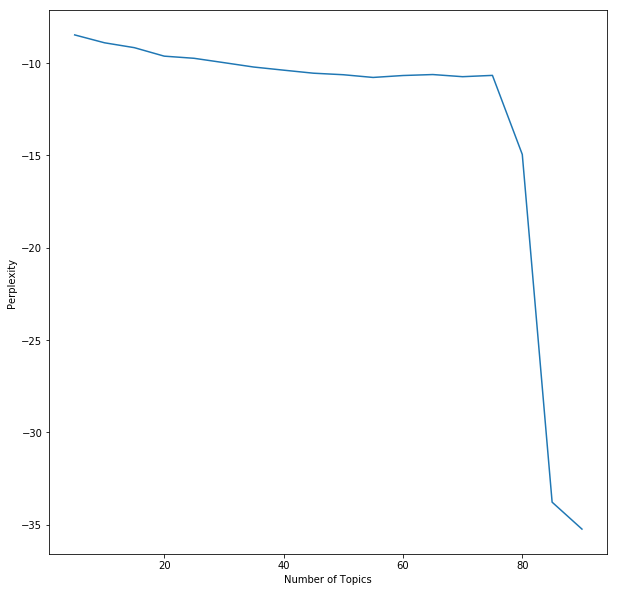

In [145]:
plt.figure(figsize=(10, 10))
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.plot(num_topics, perplexity)
plt.show()

In [146]:
best = 50
models[str(best)].print_topics(num_topics=best, num_words=20)

[(0,
  '0.099*"quality" + 0.060*"portion" + 0.060*"price" + 0.054*"le" + 0.051*"size" + 0.033*"highly" + 0.033*"simple" + 0.027*"restaurant" + 0.026*"due" + 0.024*"generous" + 0.023*"recommended" + 0.021*"truly" + 0.021*"serving" + 0.020*"family" + 0.014*"taste" + 0.012*"sadly" + 0.011*"longer" + 0.011*"100" + 0.011*"daughter" + 0.009*"cleanliness"'),
 (1,
  '0.073*"sandwich" + 0.060*"lunch" + 0.045*"breakfast" + 0.037*"delicious" + 0.029*"day" + 0.027*"menu" + 0.026*"brunch" + 0.026*"back" + 0.025*"ordered" + 0.024*"chicken" + 0.023*"waffle" + 0.021*"definitely" + 0.021*"came" + 0.020*"entree" + 0.018*"also" + 0.016*"nice" + 0.014*"little" + 0.014*"pricey" + 0.014*"bread" + 0.014*"tomato"'),
 (2,
  '0.110*"fish" + 0.076*"chip" + 0.054*"authentic" + 0.040*"eaten" + 0.029*"kept" + 0.027*"pas" + 0.026*"gem" + 0.022*"world" + 0.022*"crowded" + 0.019*"milk" + 0.017*"az" + 0.016*"greek" + 0.014*"shake" + 0.014*"mussel" + 0.013*"request" + 0.012*"corner" + 0.012*"oily" + 0.012*"consistency" 